In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPooling2D, UpSampling2D, Flatten, Activation, Reshape
from keras.models import Model, Sequential
from keras.datasets import mnist, cifar10
from IPython import display

In [19]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def preprocess_images(images):
    return (images.astype(np.float32) / 255.0).reshape((len(images), 28, 28, 1))

def preprocess_labels(labels):
    return labels.reshape(-1).astype(np.int32)

x_train = preprocess_images(x_train)
print(x_train.shape)
x_test = preprocess_images(x_test)
print(x_test.shape)
y_train = preprocess_labels(y_train)
print(y_train.shape)
y_test = preprocess_labels(y_test)
print(y_test.shape)

batch_size=128
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(x_test.shape[0]).batch(batch_size)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


In [38]:
# Adding noise to data
noise = 0.3
train_noise = x_train + noise * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape
    )
test_noise = x_test + noise * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape
    )

train_noise = np.clip(train_noise, 0., 1.)
test_noise = np.clip(test_noise, 0., 1.)

def visualise_images(array1, array2):
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

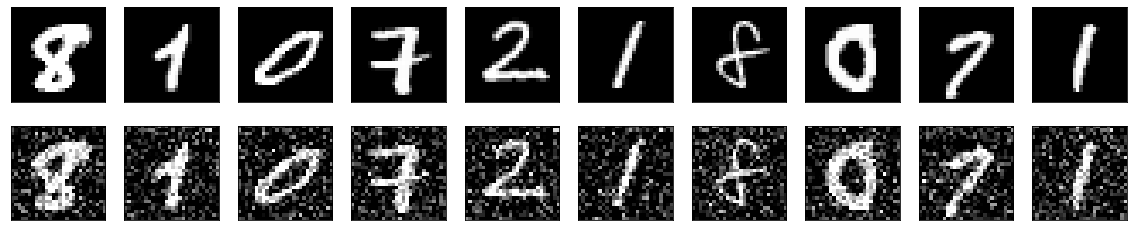

In [39]:
visualise_images(x_train,train_noise)

In [14]:
encoder = Sequential(name="encoder", 
                              layers=[Conv2D(16, (3, 3), padding='same', activation='sigmoid', input_shape=(28, 28, 1)),
                                         MaxPooling2D((2, 2), padding='same'),
                                         Conv2D(2, (3, 3), activation='sigmoid', padding='same'),
                                         MaxPooling2D((2, 2), padding='same'),
                                      ])
decoder = Sequential(name="decoder",
                              layers=[Conv2D(2, (3, 3), padding='same',  activation='sigmoid', input_shape=(7, 7, 2)),
                                      UpSampling2D((2, 2)),
                                      Conv2D(16, (3, 3), padding='same',  activation='sigmoid'),
                                      UpSampling2D((2, 2)),
                                      layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
                                      ]) 

autoencoder = Sequential(name="autoencoder", layers=[encoder, decoder])

autoencoder.summary(expand_nested=True)

classification_head = Sequential(name="classification_head", 
                                          layers=[Flatten(input_shape=(7, 7, 2)),
                                                   Dense(10)])
pretrained_classifier = Sequential(name="encoder_classifier", layers=[encoder, classification_head])

classifier = Sequential(name="classifier",
                                 layers=[Conv2D(16, (3, 3), padding='same', 
                                                activation='sigmoid', 
                                                input_shape=(28, 28, 1)),
                                        MaxPooling2D((2, 2), 
                                                     padding='same'),
                                        Conv2D(2, (3, 3), activation='sigmoid', 
                                               padding='same'),
                                        MaxPooling2D((2, 2), padding='same'),
                                         Flatten(),
                                         Dense(10)])

pretrained_classifier.summary(expand_nested=True)
classifier.summary(expand_nested=True)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 7, 7, 2)           450       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_7 (Conv2D)         (None, 28, 28, 16)        160       |
|                                                               |
| max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)     0         |
| 2D)                                                           |
|                                                               |
| conv2d_8 (Conv2D)         (None, 14, 14, 2)         290       |
|                                                               |
| max_pooling2d_5 (MaxPooling  (None, 7, 7, 2)        0         |
| 2D)                                                           |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 decoder (Sequential)        (None, 28, 28, 1)         

In [31]:
autoencoder.compile(optimizer=tf.optimizers.Adam(), 
                    loss=tf.losses.BinaryCrossentropy())

pretrained_classifier.compile(optimizer=tf.optimizers.Adam(), 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier.compile(optimizer=tf.optimizers.Adam(),
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [32]:
autoencoder.fit(x_train,x_train, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 11s 5ms/step - loss: 0.0977
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0971
Epoch 3/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0967
Epoch 4/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0965
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0963
Epoch 6/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0961
Epoch 7/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0959
Epoch 8/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0957
Epoch 9/20
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0954
Epoch 10/20
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0952
Epoch 11/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0950
Epoch 12/20
1875/1875 [==============================] - 11s 6ms/step - lo

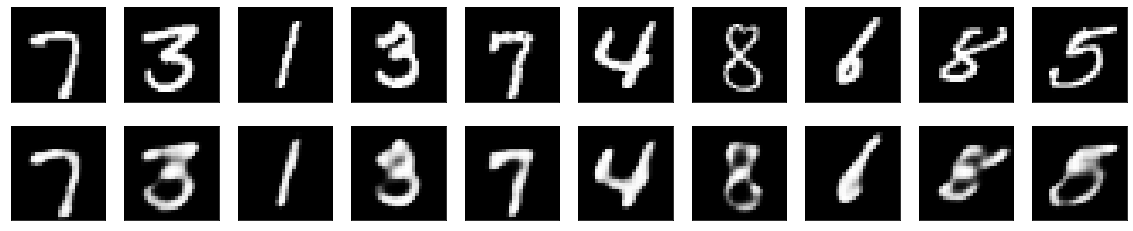

In [40]:
predictions = autoencoder.predict(x_test)
visualise_images(x_test, predictions)

In [33]:
encoder.trainable = False
pretrained_classifier.fit(train_data, epochs=25)
pretrained_classifier.evaluate(test_data)

Epoch 1/25
469/469 [==============================] - 3s 5ms/step - loss: 1.8631 - sparse_categorical_accuracy: 0.4844
Epoch 2/25
469/469 [==============================] - 2s 5ms/step - loss: 1.2584 - sparse_categorical_accuracy: 0.7243
Epoch 3/25
469/469 [==============================] - 3s 5ms/step - loss: 0.9925 - sparse_categorical_accuracy: 0.7676
Epoch 4/25
469/469 [==============================] - 3s 5ms/step - loss: 0.8464 - sparse_categorical_accuracy: 0.7930
Epoch 5/25
469/469 [==============================] - 3s 5ms/step - loss: 0.7523 - sparse_categorical_accuracy: 0.8103
Epoch 6/25
469/469 [==============================] - 3s 6ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.8251
Epoch 7/25
469/469 [==============================] - 3s 6ms/step - loss: 0.6361 - sparse_categorical_accuracy: 0.8351
Epoch 8/25
469/469 [==============================] - 3s 5ms/step - loss: 0.5975 - sparse_categorical_accuracy: 0.8434
Epoch 9/25
469/469 [============================

[0.3760605454444885, 0.8964999914169312]

In [34]:
classifier.fit(train_data, epochs=25)
classifier.evaluate(test_data)

Epoch 1/25
469/469 [==============================] - 4s 8ms/step - loss: 1.8855 - sparse_categorical_accuracy: 0.4256
Epoch 2/25
469/469 [==============================] - 4s 8ms/step - loss: 0.8661 - sparse_categorical_accuracy: 0.7735
Epoch 3/25
469/469 [==============================] - 4s 8ms/step - loss: 0.6455 - sparse_categorical_accuracy: 0.8184
Epoch 4/25
469/469 [==============================] - 4s 8ms/step - loss: 0.5428 - sparse_categorical_accuracy: 0.8453
Epoch 5/25
469/469 [==============================] - 4s 8ms/step - loss: 0.4779 - sparse_categorical_accuracy: 0.8626
Epoch 6/25
469/469 [==============================] - 4s 8ms/step - loss: 0.4313 - sparse_categorical_accuracy: 0.8750
Epoch 7/25
469/469 [==============================] - 4s 8ms/step - loss: 0.3940 - sparse_categorical_accuracy: 0.8847
Epoch 8/25
469/469 [==============================] - 4s 8ms/step - loss: 0.3623 - sparse_categorical_accuracy: 0.8939
Epoch 9/25
469/469 [============================

[0.17272669076919556, 0.9487000107765198]

In [37]:
labeled_indices = np.random.choice(x_train.shape[0], replace=False, size=1000)
image_subset = x_train[labeled_indices]
label_subset = y_train[labeled_indices]
train_subset_data = tf.data.Dataset.from_tensor_slices((image_subset, label_subset)).shuffle(image_subset.shape[0]).batch(batch_size)

classification_head_subset = tf.keras.Sequential(name="classification_head", 
                                          layers=[tf.keras.layers.Flatten(input_shape=(7, 7, 2)),
                                                  tf.keras.layers.Dense(10)])

pretrained_classifier_subset = tf.keras.Sequential(name="encoder_classifier", layers=[encoder, classification_head_subset])


classifier_subset = tf.keras.Sequential(name="classifier",
                                 layers=[Conv2D(16, (3, 3), padding='same', 
                                                activation='sigmoid', 
                                                input_shape=(28, 28, 1)),
                                        MaxPooling2D((2, 2), 
                                                     padding='same'),
                                        Conv2D(2, (3, 3), activation='sigmoid', 
                                               padding='same'),
                                        MaxPooling2D((2, 2), padding='same'),
                                         Flatten(),
                                         Dense(10)])

pretrained_classifier_subset.compile(optimizer=tf.optimizers.Adam(), 
                              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
                              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

classifier_subset.compile(optimizer=tf.optimizers.Adam(),
                   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

pretrained_classifier_subset.fit(train_subset_data, epochs=25)
pretrained_classifier_subset.evaluate(test_data)

classifier_subset.fit(train_subset_data, epochs=25)
classifier_subset.evaluate(test_data)

Epoch 1/25
8/8 [==============================] - 1s 10ms/step - loss: 2.6226 - sparse_categorical_accuracy: 0.0780
Epoch 2/25
8/8 [==============================] - 0s 6ms/step - loss: 2.4411 - sparse_categorical_accuracy: 0.1290
Epoch 3/25
8/8 [==============================] - 0s 5ms/step - loss: 2.3361 - sparse_categorical_accuracy: 0.1500
Epoch 4/25
8/8 [==============================] - 0s 5ms/step - loss: 2.2740 - sparse_categorical_accuracy: 0.1620
Epoch 5/25
8/8 [==============================] - 0s 5ms/step - loss: 2.2438 - sparse_categorical_accuracy: 0.2090
Epoch 6/25
8/8 [==============================] - 0s 6ms/step - loss: 2.2239 - sparse_categorical_accuracy: 0.2350
Epoch 7/25
8/8 [==============================] - 0s 5ms/step - loss: 2.2066 - sparse_categorical_accuracy: 0.2390
Epoch 8/25
8/8 [==============================] - 0s 5ms/step - loss: 2.1866 - sparse_categorical_accuracy: 0.2510
Epoch 9/25
8/8 [==============================] - 0s 5ms/step - loss: 2.1680 - 

[2.295623779296875, 0.08609999716281891]

In [42]:
pip install nbmerge

  Created wheel for nbmerge: filename=nbmerge-0.0.4-py2.py3-none-any.whl size=6413 sha256=a285c6b7d5248a5c8ac938e9c8505dd5d2493275cc92756676ebc91cfb7a0803
  Stored in directory: /root/.cache/pip/wheels/ce/2d/ef/1833d9299f557279f700d29a3355ad2b5fa9e35c32f84c5b3a
Successfully built nbmerge


In [44]:
!nbmerge Copy_of_exercise_9_merged.ipynb Assignment_9_encoding.ipynb > merged.ipynb

Traceback (most recent call last):
  File "/usr/local/bin/nbmerge", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/nbmerge/__init__.py", line 189, in main
    plan = parse_plan(args)
  File "/usr/local/lib/python3.7/dist-packages/nbmerge/__init__.py", line 173, in parse_plan
    raise IOError("Notebook `{}` does not exist".format(file_path))
OSError: Notebook `Copy_of_exercise_9_merged.ipynb` does not exist
